## URV for images

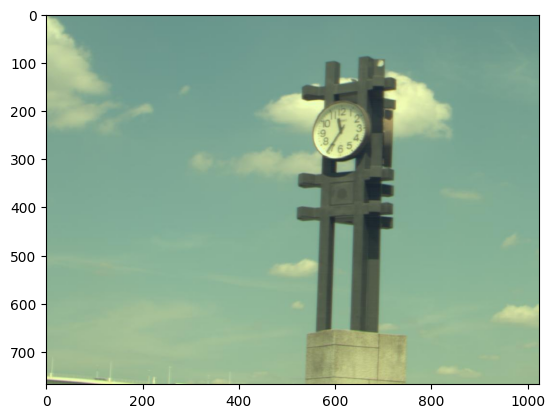

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('0002.jpg')
imgplot = plt.imshow(img)

   ---------------------------------------- 0.0/44.5 MB ? eta -:--:--
   -- ------------------------------------- 2.4/44.5 MB 14.9 MB/s eta 0:00:03
   ----- ---------------------------------- 5.8/44.5 MB 15.3 MB/s eta 0:00:03
   ------ --------------------------------- 7.1/44.5 MB 12.8 MB/s eta 0:00:03
   -------- ------------------------------- 9.4/44.5 MB 12.0 MB/s eta 0:00:03
   ----------- ---------------------------- 13.1/44.5 MB 13.3 MB/s eta 0:00:03
   ------------- -------------------------- 14.9/44.5 MB 13.4 MB/s eta 0:00:03
   -------------- ------------------------- 16.3/44.5 MB 11.5 MB/s eta 0:00:03
   ---------------- ----------------------- 18.9/44.5 MB 11.9 MB/s eta 0:00:03
   ------------------- -------------------- 22.0/44.5 MB 12.1 MB/s eta 0:00:02
   ---------------------- ----------------- 24.6/44.5 MB 12.3 MB/s eta 0:00:02
   ------------------------- -------------- 28.3/44.5 MB 12.7 MB/s eta 0:00:02
   --------------------------- ------------ 30.9/44.5 MB 12.7 MB/


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


shape of original image (768, 1024, 3)
shape gray scale (768, 1024)


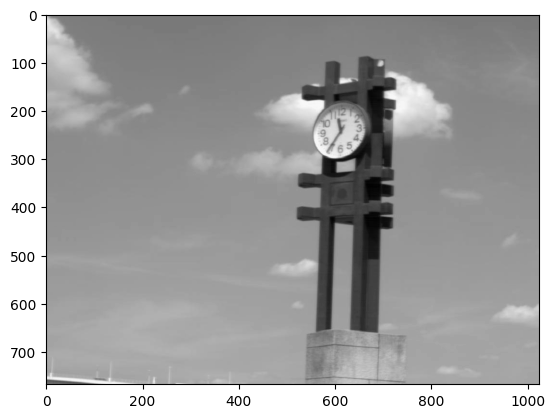

In [3]:
import numpy as np
%pip install scipy
import scipy.linalg as spl
print('shape of original image',img.shape)
rgb_weights = [0.2989, 0.5870, 0.1140]
imgg=np.dot(img,rgb_weights)
print('shape gray scale',imgg.shape)
imgplot = plt.imshow(imgg,cmap=plt.get_cmap("gray"))

In [5]:
def correlation_index(A,B):
    rhoxy=np.inner( ( (A.flat)-np.mean(A.flat))/np.std(A.flat),(B.flat-np.mean(B.flat))/np.std(B.flat))
    rhoxy = rhoxy/np.prod(A.shape)
    return rhoxy


To perform the qr factorization we use the scipy routine qr
of the  modulus linalg with pivoting true in order to have 
the elements of the rectangular matrix ordered:
    
[Qimg,Rimg,Pimg]=spl.qr(imgg,pivoting=True)

note that Pimg contains the index of the permuted columns 
of imgg and the algorithm find an orthogonal matrix
Qimg and a rectangular matrix Rimg such that 
imgg[:,Pimg]=Qimg*Rimg

print the norm of the the residual imgg[:,Pimg]-Qimg*Rimg


Compute the URV factorization by performing first the Q R factorization with pivoting and after the QR factorization on the resulting matrix Rimg transposed (Rimg^T= V B). The factorized matrix A P = Q B^T V^T. 

In [6]:
import time
t1=time.process_time()
[Qimg,Rimg,Pimg]=spl.qr(imgg,pivoting=True)
[Ql,Rl]=spl.qr(Rimg.T)
t1e=time.process_time()-t1
print('tempo con pivot',t1e)
print(np.linalg.norm(imgg[:,Pimg]-np.dot(Qimg,Rimg))/np.linalg.norm(imgg))
print(np.linalg.norm(imgg[:,Pimg]-np.dot(np.dot(Qimg,Rl.T),Ql.T))/np.linalg.norm(imgg)) #UBV factorizat

tempo con pivot 1.375
2.9040749417102447e-15
2.9518160301901023e-15


Given the tolerances 1e-1,5e-2,1e-2,5e-3 compute an approximation
of the matrix imgg by choosing only nc  columns of the matrix Qimg
and nc rows and columns of the matrix Rl, and nc column of the matrix V where nc is chosen 
by computing: 

  1) extract the diagonal elements of Rl and copy in Bdiag
    
  2) scale the absolute values of Bdiag with respect to its absolute maximum
    
  3) compute nc as  the number of elements of Bdiag that are greather of the chosen tolerance
    
plot the approximate images in gray scale and comment the results, comparing them with the same image obtained with the QR factorization. To compare the images compute the correlation between the reconstructed image and the original one by writing the two images as two vectors. 

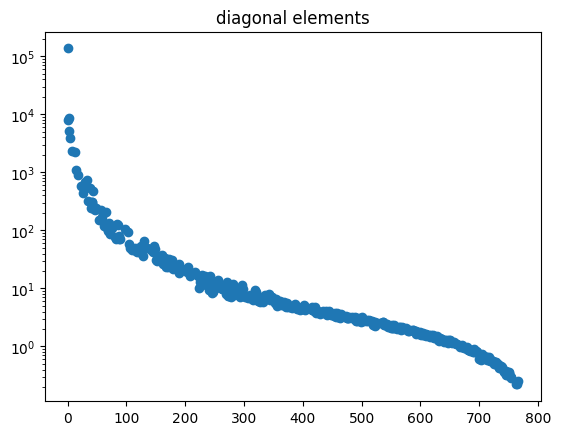

nc 1


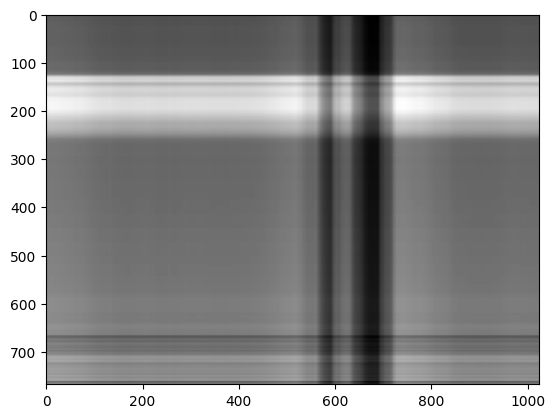

correlation index = 0.41113655418393624
nc 3


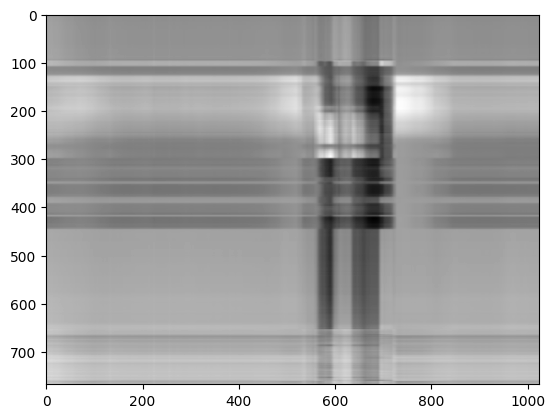

correlation index = 0.7308765484742835
nc 15


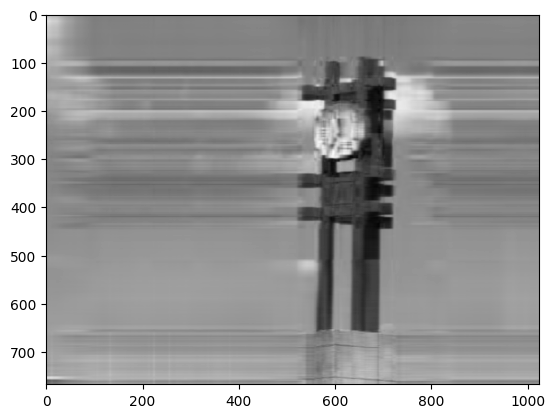

correlation index = 0.9182451990189681
nc 24


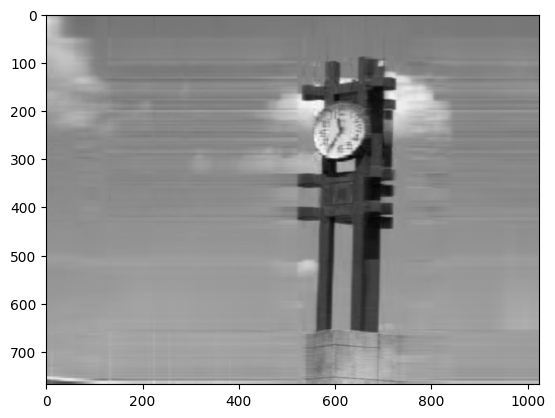

correlation index = 0.9796070205440559
nc 67


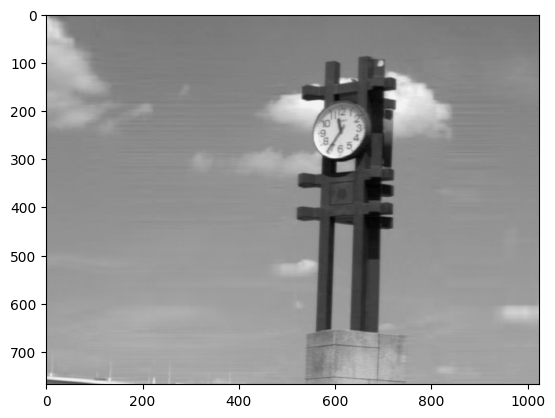

correlation index = 0.9983706780629467
nc 630


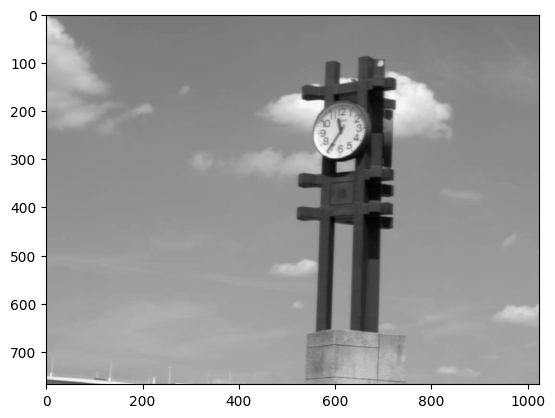

correlation index = 0.9999996794940404
nc 768


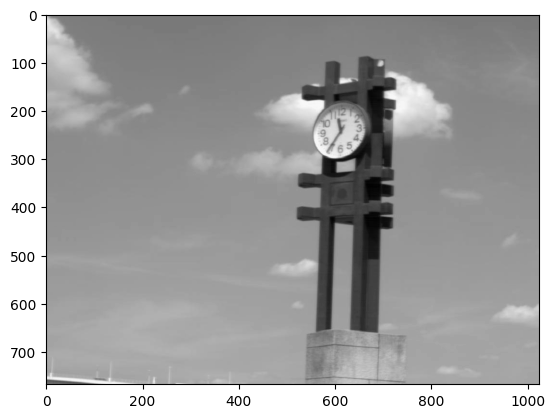

correlation index = 0.9999999999999939


In [7]:
ndi=(np.diag(Rl))
plt.semilogy(ndi,'o')
plt.title('diagonal elements')
plt.show()
tol=[1e-1,5e-2,1e-2,5e-3,1e-3,1e-5,1e-8]
for ind in tol:
 nc=np.sum(abs(ndi)/max(abs(ndi)) >= ind)
 print('nc',nc)
 QA=np.copy(Qimg[:,0:nc])
# QA basis for the column space of A
 RA=np.copy(Rl[0:nc,0:nc].T)
 QLA=np.copy(Ql[:,0:nc].T)
 Apimg=np.dot(np.dot(QA,RA),QLA)
 PTimg = np.zeros(Pimg.shape,dtype=int) 
 PTimg[Pimg]=range(Pimg.shape[0])
 Apimg=Apimg[:,PTimg]
 imgplot = plt.imshow(Apimg,cmap=plt.get_cmap("gray"))
 rhoxy=   correlation_index(imgg,Apimg)
 plt.show()
 print('correlation index =', rhoxy)


Compute the singular value decomposition of the image and compute the rank nc approximation with a norm-2 error matrix less than the tolerances used in the previous experiments. Compare the results with the QR and the URV factorization using the correlation index. 

In [8]:
Uimg, simg, Vimg = spl.svd(imgg, full_matrices=False)

print(np.linalg.norm(imgg-np.dot(Uimg*simg,Vimg),2)/simg[0])
print(np.linalg.norm(imgg-np.dot(Uimg*simg,Vimg),2))


4.352987834957229e-15
6.007687310138853e-10


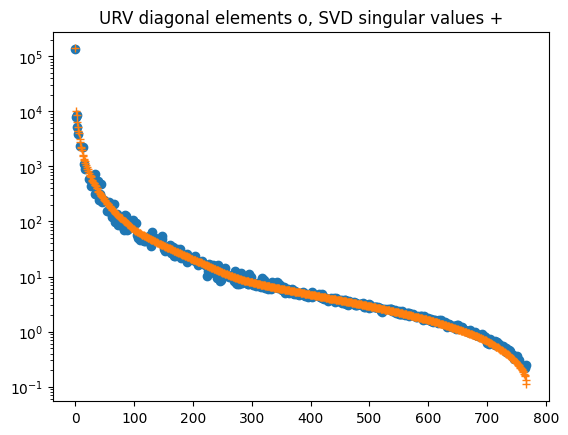

In [9]:
plt.semilogy(ndi,'o',simg,'+')
plt.title('URV diagonal elements o, SVD singular values +')
plt.show()

In [10]:
import scipy.linalg as la
AS = np.copy(np.asarray(imgg))
(nb, na) = AS.shape

meanAS=np.mean(AS,axis=0).reshape(1,na)

In [11]:
As1 = np.copy(np.asarray(imgg))
As1 -=  meanAS # compacted outer product it is the same as using the outer product (sottrae il primo elemento del vettore a tutta la prima colonna di As1, e cosi via perchè è vettore riga)
print('mean of the columns after ', np.mean(As1,axis=0)) #non è zero per via di approssimazioni numeriche

mean of the columns after  [2.85641881e-13 3.26609110e-13 2.92451248e-13 ... 2.13754940e-13
 1.08357767e-13 2.05169215e-13]


In [12]:
U, s, Vh = la.svd(As1,full_matrices=False)

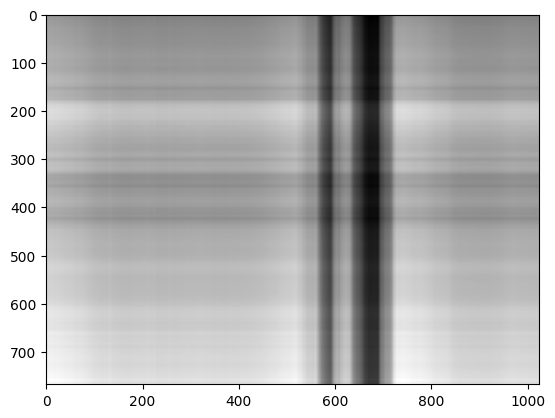

nc 1 tol = 0.1 correlation index = 0.6800403488232115


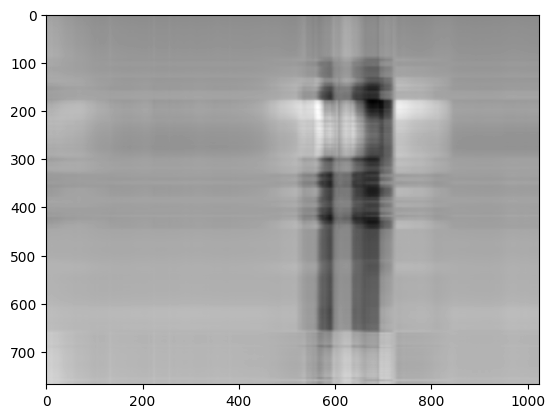

nc 3 tol = 0.05 correlation index = 0.8632725045964142


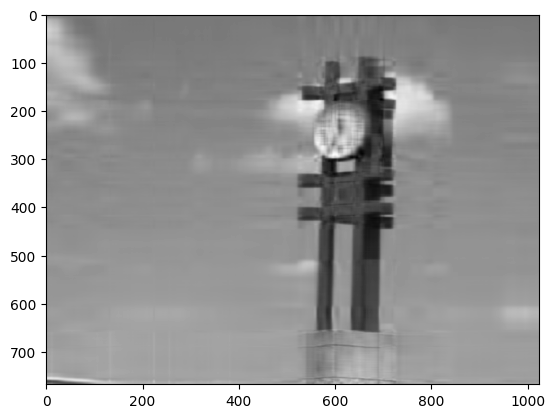

nc 15 tol = 0.01 correlation index = 0.9867183586292977


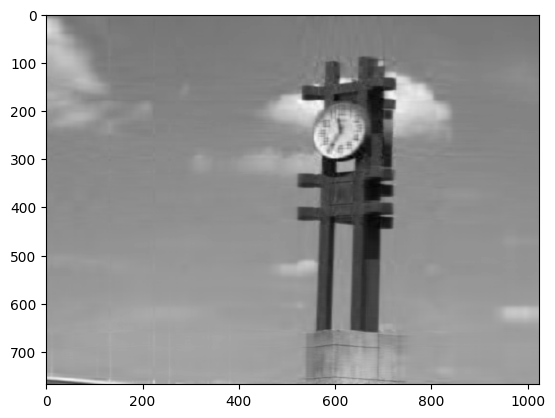

nc 25 tol = 0.005 correlation index = 0.9950493791833465


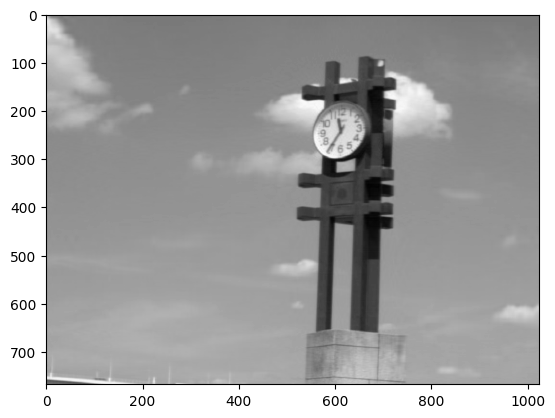

nc 69 tol = 0.001 correlation index = 0.9995632546563528


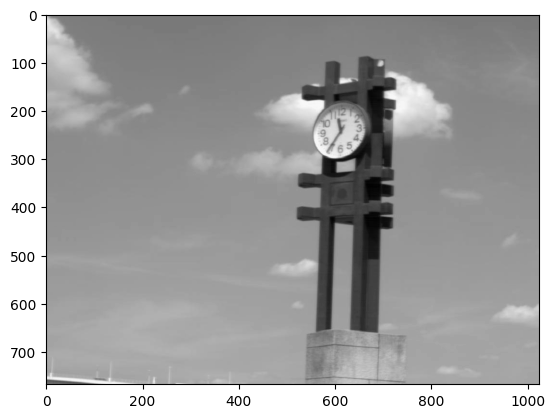

nc 768 tol = 0 correlation index = 0.9999999999999941


In [13]:
tol=[1e-1,5e-2,1e-2,5e-3,1e-3,0]
entropy=False

for ind in tol:
 if entropy:   
  f=s**2. / np.sum(s**2.) #is based on the eigenvalues of the covariance matrix
  r = simg.shape
  entropy = (-1/np.log(r))*np.sum(f*np.log(f))
  ks = int(r*entropy)
  #print('Entropy =',entropy, 'suggested k=', ks , simg[0:ks],)
  perc=1-ind
  nc = int(r*entropy*perc) #NC viene cosi scelto: r è il numero di valori singolari, entropy è la misura di quanto i valori singolari siano distribuiti, perc è la percentuale di valori singolari che si vogliono considerare. Quindi nc è il numero di valori singolari che si vogliono considerare in base a quanto sono distribuiti
  print('r*Entropy*perc =',r*entropy*perc, 'suggested k=', nc)
  Apimg=np.dot( U[:,0:nc]*s[0:nc],Vh[0:nc,:])  + meanAS   #DEVO RIOTTENERE LA MATRICE ORIGINALE
 else:
  f= (simg)/simg[0] # the approximation properties of the svd
  nc = np.sum(f >= ind)     
  Apimg=np.dot( Uimg[:,0:nc]*simg[0:nc],Vimg[0:nc,:]) 
 

 Apimg=np.dot( Uimg[:,0:nc]*simg[0:nc],Vimg[0:nc,:])
 imgplot = plt.imshow(Apimg,cmap=plt.get_cmap("gray"))
 plt.show()
 corr_ind = correlation_index(imgg,Apimg)  
 print('nc',nc,'tol =', ind,'correlation index =', corr_ind)

In [14]:
np.linalg.norm(Apimg-imgg)/simg[0]

np.float64(4.6113873128288085e-15)

In [26]:
import numpy as np
%pip install scikit-learn
from sklearn.decomposition import PCA
import time
X=np.copy(imgg)
print('shape of original image',X.shape)
ns = 40
t1=time.process_time()
pca = PCA(copy=True,n_components=ns).fit(X) #SVD full matrix
US = pca.transform(X)
#print the first 10 components as a matrix
print(pca.components_[0:2,:])
print("\n\n\nSTOP\n\n\n\n")
"""t2d=time.process_time()-t1
print( "clock  default = ", t2d )

t1=time.process_time()
pca = PCA(copy=True,n_components=ns,svd_solver='randomized').fit(X)  #SVD per matrici sparse
US = pca.transform(X)
t2d=time.process_time()-t1
print( "clock  randomized = ", t2d )


t1=time.process_time()
pca = PCA(copy=True,n_components=ns,svd_solver='arpack').fit(X) #arpack anche per matrici sparse, però questo è un metodo iterativo
US = pca.transform(X)
t2d=time.process_time()-t1
print( "clock  arpack= ", t2d )"""
#reverse the columns of X
Xr=np.copy(X)
Xr[:,0]=X[:,0]
t1=time.process_time()
pca = PCA(copy=True,n_components=ns).fit(Xr) #SVD full matrix
US = pca.transform(Xr)
print(pca.components_[0:2,:])


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: scikit-learn in c:\users\fonta\appdata\local\programs\python\python312\lib\site-packages (1.5.2)

shape of original image (768, 1024)
[[ 0.00514329  0.00512007  0.0052033  ...  0.01541681  0.01542312
   0.01542852]
 [ 0.02304391  0.02276347  0.02242636 ... -0.03165924 -0.03180556
  -0.03183807]]



STOP




[[ 0.00514329  0.00512007  0.0052033  ...  0.01541681  0.01542312
   0.01542852]
 [ 0.02304391  0.02276347  0.02242636 ... -0.03165924 -0.03180556
  -0.03183807]]



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Text retrieval

Given the  term-document matrix A and the two query vectors defined in the following code, compute the cosine similarity 
beetwen the query vectors and the matrix A and find  which documents are meaningful for the  given query.  Define an additional query and analyze the result. Compare the results obtained using the QR factorization with the one obtained with the singular value decomposition. 

In [ ]:
import sklearn
import sklearn.feature_extraction
np.set_printoptions(suppress=True)
vectorizer = sklearn.feature_extraction.text.CountVectorizer(min_df=1)
documents = [
'The rank of a matrix is the maximum number of linearly independent columns.',
'The column space of a matrix A is called range of A.',
'The two norm of a vector is called Euclidean norm.',
'The function norm satisfies the triangular inequality.',
'The inverse of an orthogonal matrix is its transpose.',
'The product of an orthogonal matrix and its traspose is the identity matrix.',
'The matrix vector product is not commutative',
'The rank of a matrix is the maximum number of  linearly independent rows.',
'A set of orthogonal vectors is a linearly independent set.',
'The columns of an orthogonal matrix are a set of orthogonal vectors.',
'A normed vectorial space is a space with an inner product norm.',
'An inner product space is a vectorial space with an inner product',
'A norm can be induced by an inner product.']

X = vectorizer.fit_transform(documents).toarray()
print('vectorizer.vocabulary_: {0}'.format(vectorizer.vocabulary_))
A=X.T
# query vectors
query1text = ['rank of a matrix?']
query1 = vectorizer.transform(query1text).toarray()
query1 = query1.T
query2text = ['euclidean norm']
query2 = vectorizer.transform(query2text).toarray()
query2 = query2.T

In [ ]:
(m,n)=A.shape
print(m,n)
eu=np.array(np.zeros(n))
for i in range(n):
    eu[i] = np.linalg.norm(A[:,i],2)

In [ ]:
As= np.dot(A,np.diag(1/eu))

In [ ]:
query1text = ['rank of a matrix?']
query1 = vectorizer.transform(query1text).toarray()
print('query1: {0}'.format(query1))
print(query1.shape)
query1 = query1.T
print(query1.shape)

In [ ]:
# cos of the angles  cos(teta) = x^T y / (||x||*||y||)
np.dot(query1.T,As)/np.linalg.norm(query1,2) # the vector contains the inner product query1.T*As_*1 (first column), query1.T*As_*2
# if the threshold is 0.5 the two documents related to this query  are D1,D4

In [ ]:
query2text = ['euclidean norm']
query2 = vectorizer.transform(query2text).toarray()
query2 = query2.T
# scaled query vector
#query2=query2/np.linalg.norm(query2,2)

In [ ]:
# cos of the angles
np.dot(query2.T,As)/np.linalg.norm((query2),2)

Compute the QR factorization, with pivoting true,  of the scaled term-document matrix and use the QR factors to compute the cosine similarity. Compute an approximation of the term-document matrix by using nc columns of Q and nc rows of R (as in the first exercise). Use this approximation to compute again the cosine similarity and comment the results.

In [ ]:
import scipy.linalg as spl
[Q,R,P]=spl.qr(As,pivoting=True)
print(np.diag(R))


In [ ]:
print(m)
r = 2
print(r)
QA=np.copy(Q[:,0:r])
# QA basis for the column space of A
RA=np.copy(R[0:r,:])
# In general, it is necessary to use column 
# pivoting during the QR factorization to ensure that the zeros appear 
# at the bottom of the matrix AP = QR
QAO =np.copy( Q[:,r:m])
# The  columns of QAO are a basis for the orthogonal
# complement of the column space of AP and so of the column space of A.
# Column pivoting provides important numerical advantages without changing the database, as
# permuting the columns of A results only in a reordering of the document vectors.

In [ ]:
costet=np.dot(As[:,P].T,query1)/np.linalg.norm(query1,2)
print(np.transpose(costet))
costet=np.dot(RA.T,np.dot(QA.T,query1))/np.linalg.norm(query1,2)
print(np.transpose(costet))
print(P)

In [ ]:
m=2
RAs=np.copy(R) 
RAs[r:m,:]=0
E = np.dot(Q,RAs)-np.dot(Q,R)
AE = As+E
AEeu=np.array(np.zeros((1,n)))
for i in range(n):
    AEeu[0,i] = np.linalg.norm(AE[:,i],2)

QAs=np.copy(Q[:,0:r])
# QAs basis for the column space of a subsapce of the columns space A
RAs=RAs[0:r,:]

#(QAs,RAs)=np.linalg.qr(AE)

costeta1=np.dot(RAs.T,np.dot(QAs.T,query1))/(AEeu.T*np.linalg.norm((query1),2))
print('cos query 1')
print(costeta1)

print('cos query 2')
costeta2=np.dot(RAs.T,np.dot(QAs.T,query2))/(AEeu.T*np.linalg.norm((query2),2))
print(costeta2)